# CS 437/5317 Deep Learning - Tutorial 3

## Computation Graphs

We discussed computation graphs in class, in context of Linear Models, Perceptrons and Neural Networks. Let's now look a closer at them. Consider this mathematical function:
$$f(x, y, x) = (x + y) * z$$
It consists of 2 binary operations, with the parentheses defining a notion of order of these operations. This expression can be represented by a simple computation graph.

![](https://cdn-images-1.medium.com/max/1600/0*ohO11wTD8DCUMVR8)

The advantage of this notation/framework is that it is very easy to notice the hierarchical nature of computations. We can represent it in a methematical notation as well:
$$g(i, j) = i + j$$
$$h(p, q) = p * q$$
$$f(x, y, z) = h(g(x, y), z)$$

With concrete numeric inputs this nested/hierarchical structure reveals its advantage. The overall computation (no matter how complex), can be broken down into smaller sub-computations. 
$$f(1, 2, 3) = h(g(1, 2), 3)$$
$$g(1, 2) = 1 + 2 = 3$$
$$f(1, 2, 3) = h(3, 3)$$
$$h(3, 3) = 3*3 = 9$$
$$f(1, 2, 3) = 9$$

![](https://cdn-images-1.medium.com/max/1600/0*DxiGsw0MskmqsL2a)

Many deep learning frameworks use this idea of computation graphs to represent computations so that teh smaller computations can be executed by specialized functions to speed them up. These graphs also allow the frameworks (like TensorFlow) to identify independant parts of the computation and run them on independant GPUs in parallel. 

Consider a different example, which is more relevant to our cause. 
$$f(x, y) = ax² + bxy + cy²$$
Here $a$, $b$ and $c$ are scalars, and can be thought of as the weights or parameters of the model. 
![](https://cdn-images-1.medium.com/max/1600/0*qe8i0Cs1Hbs8MOrF)
We can see that the scalars also show up as *source* nodes in the graph. Various techniques exist to compute the derivative of such graphs with respect to the parameters automatically. 

Now let's consider a more *real* example. A classifier which predicts a person's relationship status using some features about that person. This model will be a huge, complex, nested mess of an expression but we can turn it into a black-box:
![](https://cdn-images-1.medium.com/max/1600/0*FdcwEBNZW7RKw2jj)
For the simple purpose of feature selection or model evaluation, this picture of the process is a sufficient representation of the model. But if we need more insight into the model, for debugging maybe, we can get that too.
![](https://cdn-images-1.medium.com/max/1600/1*H7ixk7g1mRkf77lHw6_dLQ.png)

We can also go *even deeper*
![](https://cdn-images-1.medium.com/max/1600/0*1psj0a2PsRE9DoHm)

This notion of the computation graph is core to the design of TensorFlow. Nowadays we have higher-level wrapper APIs like Keras to access the model but the guts of the framework are still the same.

*Details of this discussion can be found in this [article](https://medium.com/tebs-lab/deep-neural-networks-as-computational-graphs-867fcaa56c9)*

## Imports

In [147]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.utils import plot_model, to_categorical
import keras.backend as K

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import display

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

## Hyperarameters

In [140]:
batch_size = 128
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
epochs = 3

## Load and Process Dataset

Split between train, val and test sets

In [46]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [47]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)
x_train.shape, x_val.shape

((48000, 28, 28), (12000, 28, 28))

In [48]:
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

48000 train samples
12000 validation samples
10000 test samples


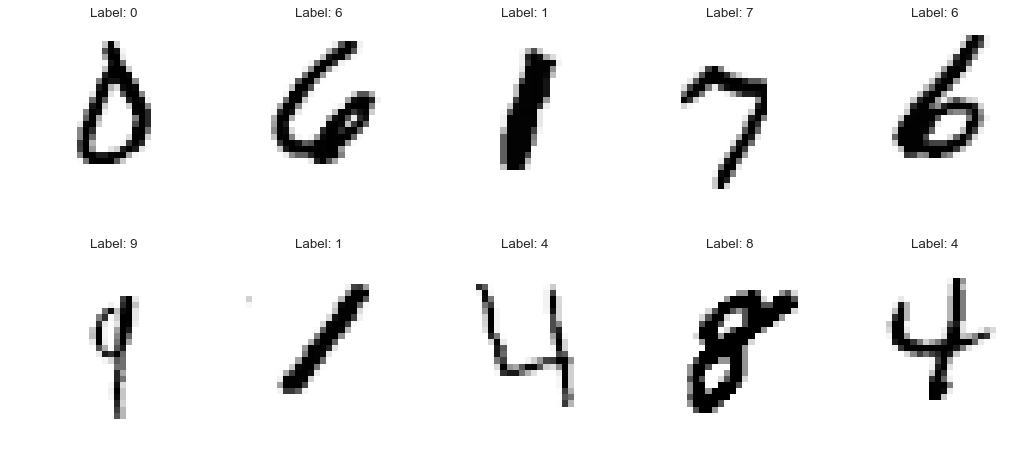

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,7), dpi=80)

i = 0
for r in range(2):
    for c in range(5):
        axes[r,c].imshow(x_train[i,:,:])
        axes[r,c].grid(False)
        axes[r,c].axis('off')
        axes[r,c].set_title(f'Label: {y_train[i]}');
        i += 1

Reshape and mean-center images

In [78]:
x_train = x_train.reshape(48000, 28*28)
x_val = x_val.reshape(12000, 28*28)
x_test = x_test.reshape(10000, 28*28)

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_val /= 255
x_test /= 255

Convert labels into one-hot encoding

In [79]:
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

## Build Model

In [141]:
model = Sequential(name='tutorial_model')

model.add(Dense(50, activation='relu', input_shape=(784,), name='input_l'))
model.add(Dense(50, activation='relu', name='hidden_l'))
model.add(Dense(num_classes, activation='softmax', name='output_l'))

plot_model(model, 'model.png', show_shapes=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_l (Dense)              (None, 50)                39250     
_________________________________________________________________
hidden_l (Dense)             (None, 50)                2550      
_________________________________________________________________
output_l (Dense)             (None, 10)                510       
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________


In [142]:
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

## Training

In [143]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val), 
                    verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 3s 59us/step - loss: 0.4382 - acc: 0.8792 - val_loss: 0.2631 - val_acc: 0.9233
Epoch 2/3
48000/48000 [==============================] - 2s 40us/step - loss: 0.2096 - acc: 0.9388 - val_loss: 0.2013 - val_acc: 0.9406
Epoch 3/3
48000/48000 [==============================] - 2s 41us/step - loss: 0.1559 - acc: 0.9536 - val_loss: 0.1643 - val_acc: 0.9528


,val_loss,val_acc,loss,acc
0,0.263095,0.923333,0.438231,0.879229
1,0.201340,0.940583,0.209585,0.938833
2,0.164268,0.952750,0.155882,0.953604


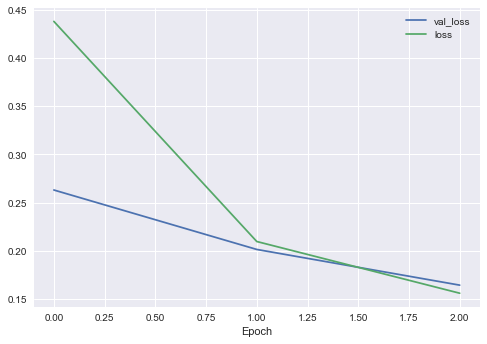

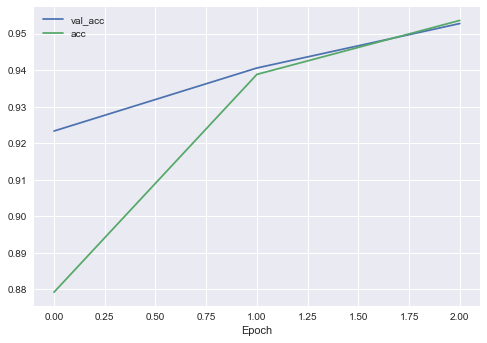

In [152]:
h = pd.DataFrame(history.history)
display(h)

h[['val_loss','loss']].plot();
plt.gca().set_xlabel('Epoch');

h[['val_acc','acc']].plot();
plt.gca().set_xlabel('Epoch');

## Model Evaluation

In [124]:
score = model.evaluate(x_test, y_test, 
                       verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 0s 22us/step
Test loss: 0.2182283065840602
Test accuracy: 0.9363


In [125]:
preds = model.predict(x_test, 
                      batch_size=batch_size, 
                      verbose=1)

10000/10000 [==============================] - 0s 14us/step


In [126]:
c_mat = confusion_matrix(y_test.argmax(axis=1), 
                         preds.argmax(axis=1), 
                         labels=class_labels)
c_mat

array([[ 960,    0,    0,    1,    0,    3,    8,    5,    3,    0],
       [   0, 1115,    0,    5,    1,    0,    4,    2,    8,    0],
       [   8,    2,  934,   20,    7,    3,   11,   22,   24,    1],
       [   1,    1,   14,  952,    1,    8,    2,   20,    8,    3],
       [   1,    2,    2,    1,  928,    0,   14,    5,    4,   25],
       [   6,    1,    1,   36,    3,  810,   13,   10,    8,    4],
       [   7,    3,    4,    3,    5,   12,  921,    3,    0,    0],
       [   0,    9,   14,    5,    3,    0,    0,  982,    0,   15],
       [   8,    4,    7,   29,    9,   21,   14,   18,  853,   11],
       [   9,    6,    1,   14,   27,    4,    1,   35,    4,  908]],
      dtype=int64)

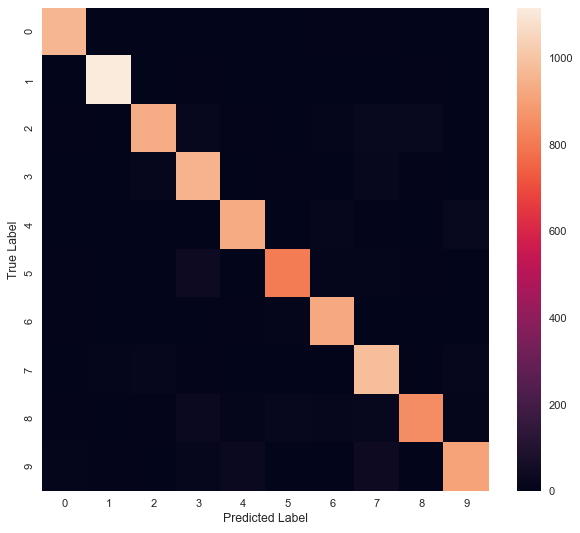

In [127]:
fig, ax = plt.subplots(figsize=(9,8), dpi=80)
sns.heatmap(c_mat, 
            xticklabels=class_labels, 
            yticklabels=class_labels,
            ax=ax)
ax.set(xlabel='Predicted Label', ylabel='True Label');

## Making Predictions

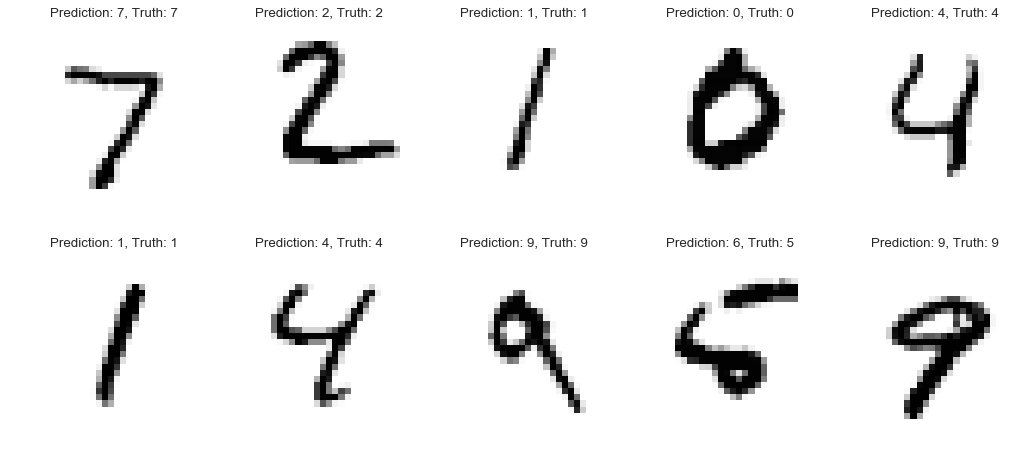

In [128]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,7), dpi=80)

i = 0
for r in range(2):
    for c in range(5):
        axes[r,c].imshow(x_test[i].reshape((28,28)))
        axes[r,c].grid(False)
        axes[r,c].axis('off')
        axes[r,c].set_title(f'Prediction: {preds[i,:].argmax()}, Truth: {y_test[i,:].argmax()}');
        i += 1

## Custom Loss Function

In [136]:
def custom_loss(yTrue, yPred):
    return K.sum(K.log(yTrue) - K.log(yPred))

def custom_MSE(yTrue, yPred):
    return K.mean(K.pow(yTrue - yPred, 2))

In [137]:
opti = RMSprop(lr=0.001, rho=0.9, decay=0.0)

model.compile(loss=customL_MSE,
              optimizer=opti,
              metrics=['accuracy'])